In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [3]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


## Data summary
 

In [4]:
# Reads from Supplemental File 
reads = pd.read_excel('Data/GSE193834_Supplemental_File_12_Calu-3_Cas12a_KO_SecondaryLibrary_Goujon_1_.xlsx', sheet_name='Calu3_genomewide_reads')
reads



,Construct Barcode,pDNA,Calu3-CP1660-initial population screen #1,Calu3-CP1660-resistant population screen #1,Calu3-CP1660-initial population screen #2,Calu3-CP1660-resistant population screen #2
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,81,7976,1,5887,105457
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,89,4668,0,5161,1655
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,147,804,0,3319,260
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,107,3562,0,4522,2041
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,120,8376,0,6494,4860
...,...,...,...,...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,116,7555,0,4471,3255
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,156,14124,1,9559,9545
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,160,13904,0,9139,11874
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,77,6142,2,4866,5519


In [6]:
# Gene Annotations
chip = pd.read_excel('Data/GSE193834_Supplemental_File_12_Calu-3_Cas12a_KO_SecondaryLibrary_Goujon_1_.xlsx', sheet_name='Calu3_guide_mapping')
# Merge reads with annotations
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,Calu3-CP1660-initial population screen #1,Calu3-CP1660-resistant population screen #1,Calu3-CP1660-initial population screen #2,Calu3-CP1660-resistant population screen #2
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,ACE2,81,7976,1,5887,105457
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,ACR,89,4668,0,5161,1655
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,ACTR2,147,804,0,3319,260
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,ACTR3,107,3562,0,4522,2041
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,ADAM7,120,8376,0,6494,4860
...,...,...,...,...,...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,ONE_INTERGENIC_SITE_53,116,7555,0,4471,3255
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,ONE_INTERGENIC_SITE_121,156,14124,1,9559,9545
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,ONE_INTERGENIC_SITE_54,160,13904,0,9139,11874
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,ONE_INTERGENIC_SITE_32,77,6142,2,4866,5519


In [7]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Calu3-CP1660-initial population screen #1_lognorm,Calu3-CP1660-resistant population screen #1_lognorm,Calu3-CP1660-initial population screen #2_lognorm,Calu3-CP1660-resistant population screen #2_lognorm
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,ACE2,8.985132,9.655216,10.943617,9.495982,13.917809
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,ACR,9.120759,8.883623,0.000000,9.306381,7.929964
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,ACTR2,9.843676,6.360691,0.000000,8.670743,5.291113
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,ACTR3,9.386057,8.494454,0.000000,9.116013,8.231289
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,ADAM7,9.551247,9.725727,0.000000,9.637370,9.480182
...,...,...,...,...,...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,ONE_INTERGENIC_SITE_53,9.502404,9.577083,0.000000,9.099680,8.902879
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,ONE_INTERGENIC_SITE_121,9.929315,10.478849,10.943617,10.194541,10.452979
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,ONE_INTERGENIC_SITE_54,9.965804,10.456216,0.000000,10.129775,10.767766
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,ONE_INTERGENIC_SITE_32,8.912216,9.278794,11.943250,9.221605,9.663392


## Quality Control
### Population Distributions

['Calu3-CP1660-initial population screen #1_lfc', 'Calu3-CP1660-resistant population screen #1_lfc'] ['Calu3-CP1660-initial population screen #2_lfc', 'Calu3-CP1660-resistant population screen #2_lfc']


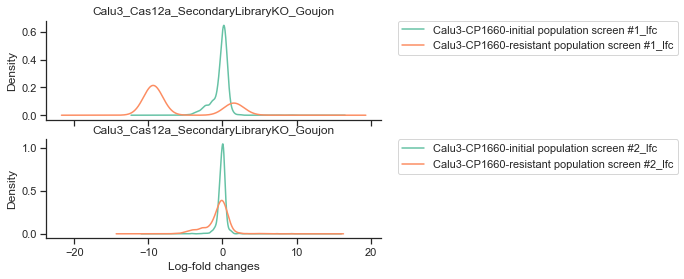

In [8]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-2:])
paired_cols = (True, [pair1, pair2])
print(pair1, pair2)
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Calu3_Cas12a_SecondaryLibraryKO_Goujon')


### Distributions of control sets 

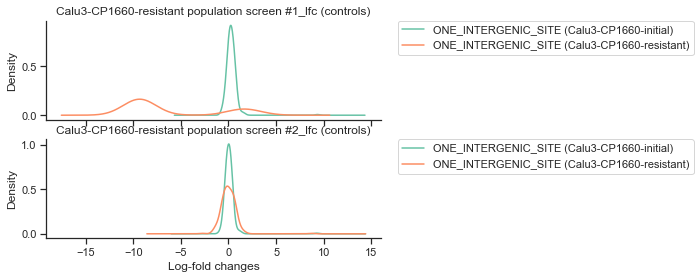

In [9]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'Calu3_Cas12a_SecondaryLibraryKO_Goujon')


Since screen 1 resistant population doesn't pass QC (poor read count quality), dropping for remainder of analysis

In [10]:
if all(item in pair1 for item in pDNA_lfc.columns):
    pDNA_lfc = pDNA_lfc.copy().drop(pair1, axis=1)

if pair1 in paired_cols[1]:
    paired_cols[1].remove(pair1)


### ROC_AUC

Essential gene set: Hart et al., 2015 <br>
Non-essential gene set: Hart et al., 2014 

Text(0, 0.5, 'True Positive Rate (essential)')

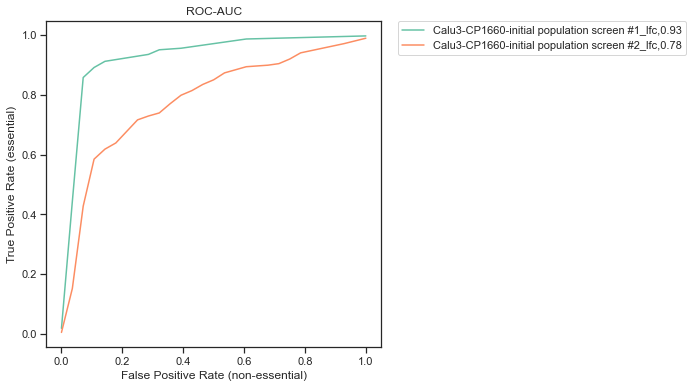

In [11]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [12]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Calu3-CP1660-initial population screen #1_lfc,Calu3-CP1660-resistant population screen #1_lfc,Calu3-CP1660-initial population screen #2_lfc,Calu3-CP1660-resistant population screen #2_lfc
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,0.670084,1.958485,0.510850,4.932677
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,-0.237136,-9.120759,0.185622,-1.190796
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,-3.482984,-9.843676,-1.172932,-4.552563
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,-0.891603,-9.386057,-0.270044,-1.154768
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,0.174480,-9.551247,0.086123,-0.071065
...,...,...,...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,0.074679,-9.502404,-0.402724,-0.599525
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,0.549534,1.014302,0.265227,0.523664
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,0.490412,-9.965804,0.163971,0.801963
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,0.366577,3.031034,0.309388,0.751175


In [13]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                          modified  \
0  Calu3-CP1660-resistant population screen #2_lfc   

                                     unperturbed  
0  Calu3-CP1660-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,Calu3-CP1660-resistant population screen #2_lfc,4.406747,3.771761,Calu3-CP1660-initial population screen #2_lfc,4.932677,0.510850
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,Calu3-CP1660-resistant population screen #2_lfc,-1.039584,-0.889787,Calu3-CP1660-initial population screen #2_lfc,-1.190796,0.185622
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,Calu3-CP1660-resistant population screen #2_lfc,-1.637150,-1.401246,Calu3-CP1660-initial population screen #2_lfc,-4.552563,-1.172932
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,Calu3-CP1660-resistant population screen #2_lfc,-0.005762,-0.004932,Calu3-CP1660-initial population screen #2_lfc,-1.154768,-0.270044
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,Calu3-CP1660-resistant population screen #2_lfc,0.296639,0.253895,Calu3-CP1660-initial population screen #2_lfc,-0.071065,0.086123
...,...,...,...,...,...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,Calu3-CP1660-resistant population screen #2_lfc,0.829572,0.710036,Calu3-CP1660-initial population screen #2_lfc,-0.599525,-0.402724
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,Calu3-CP1660-resistant population screen #2_lfc,0.504828,0.432085,Calu3-CP1660-initial population screen #2_lfc,0.523664,0.265227
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,Calu3-CP1660-resistant population screen #2_lfc,0.999912,0.855831,Calu3-CP1660-initial population screen #2_lfc,0.801963,0.163971
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,Calu3-CP1660-resistant population screen #2_lfc,0.639215,0.547108,Calu3-CP1660-initial population screen #2_lfc,0.751175,0.309388


In [14]:
# if individual numbers not assigned to controls, add row index to control name
for i, row in chip.iterrows():
    if 'INTERGENIC' in row['Gene Symbol']:
        chip.loc[i, 'Gene Symbol'] = 'ONE_INTERGENIC_SITE_' + str(i)

guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=2, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,ACE2
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,ACR
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,ACTR2
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,ACTR3
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,ADAM7
...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,ONE_INTERGENIC_SITE_53
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,ONE_INTERGENIC_SITE_121
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,ONE_INTERGENIC_SITE_54
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,ONE_INTERGENIC_SITE_32


In [15]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Calu3-CP1660-resistant population screen #2_lfc,ACE2,2,4.977549,0.614962,5.140567,2.739100e-07,0.000187
1,Calu3-CP1660-resistant population screen #2_lfc,ACR,2,-0.607642,0.144108,-0.443318,6.575361e-01,0.984146
2,Calu3-CP1660-resistant population screen #2_lfc,ACTR2,2,-4.475258,-1.168058,-1.898648,5.761073e-02,0.469116
3,Calu3-CP1660-resistant population screen #2_lfc,ACTR3,2,-2.995916,-0.827047,-0.942509,3.459319e-01,0.961056
4,Calu3-CP1660-resistant population screen #2_lfc,ADAM7,2,0.018634,-0.016901,0.743107,4.574169e-01,0.965351
...,...,...,...,...,...,...,...,...
679,Calu3-CP1660-resistant population screen #2_lfc,ZNF572,2,-0.485898,0.114411,-0.205915,8.368577e-01,0.990238
680,Calu3-CP1660-resistant population screen #2_lfc,ZNF594,2,0.164291,0.097689,0.613810,5.393406e-01,0.983794
681,Calu3-CP1660-resistant population screen #2_lfc,ZNF7,2,-0.437789,0.006693,0.129812,8.967149e-01,0.990238
682,Calu3-CP1660-resistant population screen #2_lfc,ZNF703,2,0.046941,0.099457,0.471079,6.375840e-01,0.983794


In [16]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 2, guide_max = 4)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Calu3-CP1660-resistant population screen #2_lfc']


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,GACTACAATGAGAGGCTCTGGGCTAATTTCTACTATCGTAGATAAG...,ACE2,Calu3-CP1660-resistant population screen #2_lfc,4.406747,3.771761,Calu3-CP1660-initial population screen #2_lfc,4.932677,0.510850
1,GTGTGGGCGCTTCATTGGGCCGGTAATTTCTACTATCGTAGATACG...,ACR,Calu3-CP1660-resistant population screen #2_lfc,-1.039584,-0.889787,Calu3-CP1660-initial population screen #2_lfc,-1.190796,0.185622
2,TAGCTCCCAGATGGACGTATCATTAATTTCTACTATCGTAGATTAG...,ACTR2,Calu3-CP1660-resistant population screen #2_lfc,-1.637150,-1.401246,Calu3-CP1660-initial population screen #2_lfc,-4.552563,-1.172932
3,AGGAGCGCTATAGTTATGTCTGCTAATTTCTACTATCGTAGATCCT...,ACTR3,Calu3-CP1660-resistant population screen #2_lfc,-0.005762,-0.004932,Calu3-CP1660-initial population screen #2_lfc,-1.154768,-0.270044
4,CTAGGCTCAAATTACAGTGAAACTAATTTCTACTATCGTAGATTCT...,ADAM7,Calu3-CP1660-resistant population screen #2_lfc,0.296639,0.253895,Calu3-CP1660-initial population screen #2_lfc,-0.071065,0.086123
...,...,...,...,...,...,...,...,...
1363,GAGTCAGTTCAATACCAGGTGCTTAATTTCTACTATCGTAGATCCT...,ONE_INTERGENIC_SITE_53,Calu3-CP1660-resistant population screen #2_lfc,0.829572,0.710036,Calu3-CP1660-initial population screen #2_lfc,-0.599525,-0.402724
1364,CAGTACTCCTGCAGTGATCAGTCTAATTTCTACTATCGTAGATGAT...,ONE_INTERGENIC_SITE_121,Calu3-CP1660-resistant population screen #2_lfc,0.504828,0.432085,Calu3-CP1660-initial population screen #2_lfc,0.523664,0.265227
1365,TGAGGCATTACGACGGTCCGTTCTAATTTCTACTATCGTAGATTCG...,ONE_INTERGENIC_SITE_54,Calu3-CP1660-resistant population screen #2_lfc,0.999912,0.855831,Calu3-CP1660-initial population screen #2_lfc,0.801963,0.163971
1366,GCTATCCCCGTGGAGCCGATGAATAATTTCTACTATCGTAGATGTA...,ONE_INTERGENIC_SITE_32,Calu3-CP1660-resistant population screen #2_lfc,0.639215,0.547108,Calu3-CP1660-initial population screen #2_lfc,0.751175,0.309388


In [17]:
# with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Calu3_Cas12a_SecondaryLibraryKO_Goujon.xlsx') as writer:  
#     gene_residual_sheet.to_excel(writer, sheet_name='Calu3_avg_zscore', index =False)
#     reads.to_excel(writer, sheet_name='Calu3_genomewide_reads', index =False)
#     guide_mapping.to_excel(writer, sheet_name='Calu3_guide_mapping', index =False)

### Cas12a KO summary plot

In [18]:
def alphabetical_scatter(df, title, filename, num_hits, score_col = 'residual_zscore', pos_res=True):
    '''
    Inputs: 1. df: data frame with data to plot
            2. title: title of plot
            3. filename
            4. score_col: column with data for y-axis
            5. pos_res: bool determining if positive hits are resistance hits (default = True)
    
    '''
    
    df_alphabetical = df.copy().sort_values(by='Gene Symbol').reset_index(drop=True)
    df_alphabetical['Alphabetical_Position'] = df_alphabetical.index + 1
    # Bool col to flag 'LOC' or control genes as pseudogenes so they aren't annotated
    df_alphabetical['Pseudogene'] = False
    for i in range(len(df_alphabetical)):
        gene = df_alphabetical.loc[i, 'Gene Symbol']
        if (gene.startswith('LOC')) or ('_' in gene):
            df_alphabetical.loc[i, 'Pseudogene'] = True
    
    if 'Calu3 Cal' in title:
        fig, ax = plt.subplots(figsize = (12, 4))
    else:
        fig, ax = plt.subplots(figsize = (6, 4))

    s = sns.scatterplot(data=df_alphabetical, x=df_alphabetical['Alphabetical_Position'], y=df_alphabetical[score_col], color='grey', edgecolor=None, s=10, rasterized = True)
    # Annotate top 20 hits (positive z-score)
    pos_num_hits = num_hits[0]

    df_alphabetical_no_pseudo = df_alphabetical[~df_alphabetical['Pseudogene']]
    annot_pos_genes = df_alphabetical_no_pseudo.nlargest(pos_num_hits, score_col).reset_index(drop=True)
    
    if pos_res: # for knockout screens 
        pos_label = 'Resistance (Pro-viral) Hits'
        pos_color = sns.color_palette('muted')[0]
        neg_label = 'Sensitization (Anti-viral) Hits'
        neg_color = sns.color_palette('muted')[3]
        if 'Calu3 Cal' in title: 
            neg_label = 'Sensitization (Anti-viral) Hits'
            neg_color = sns.color_palette('muted')[3]
#     else: # for activation screen resistance and sensitization hits have opposite signs for z-scores
#         neg_label = 'Resistance (Pro-viral) Hits'
#         neg_color = sns.color_palette('muted')[0]
#         pos_label = 'Sensitization (Anti-viral) Hits'
#         pos_color = sns.color_palette('muted')[3]
    
    s = sns.scatterplot(data=annot_pos_genes, x=annot_pos_genes['Alphabetical_Position'], y=annot_pos_genes[score_col], label = pos_label, color = pos_color, edgecolor=None, s=10, rasterized = True)
    texts=[]
    for i, row in annot_pos_genes.iterrows():
        texts.append(plt.text(row['Alphabetical_Position']+0.25, row[score_col]+0.25, row['Gene Symbol'], fontsize=10,
                                      color = 'black'))
    # Annotate top 20 hits (negative z-score)
#     if 'Calu3 Cal' in title: 
    annot_neg_genes = df_alphabetical.nsmallest(num_hits[1], score_col).reset_index(drop=True)
    # Remove LOC or controls from annot_pos_genes
    drop_count = 0
    drop_idx = []
    for i in range(len(annot_neg_genes)):
        gene = annot_neg_genes.loc[i, 'Gene Symbol']
        if ('LOC'in gene) or ('_' in gene):
            drop_idx.append(i)
            drop_count +=1
            print(drop_count, drop_idx, gene)
            annot_neg_genes = df_alphabetical.nlargest(num_hits[0]+drop_count, score_col).reset_index(drop=True)
        if drop_idx:
            annot_neg_genes.drop(drop_idx, axis=0)

    s = sns.scatterplot(data=annot_neg_genes, x=annot_neg_genes['Alphabetical_Position'], y=annot_neg_genes[score_col], label = neg_label, color =neg_color, edgecolor=None, s=10, rasterized = True)
    for i, row in annot_neg_genes.iterrows():
        texts.append(plt.text(row['Alphabetical_Position'], row[score_col], row['Gene Symbol'], fontsize=10,
                                      color = 'black'))

    plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.1), borderaxespad=0.)
#     plt.xticks(fontsize=7)
#     plt.yticks(fontsize=7)
    plt.xlabel('Gene (Alphabetical position)')#, fontsize = 7)
    plt.ylabel('Gene-level mean z-score')#, fontsize = 7)
    plt.title(title)#, fontsize=7)
    sns.despine()
#     gpp.savefig('../../../Figures/ScreenSummaryPlots_v2/'+filename+'_plot.pdf', dpi = 300)
    


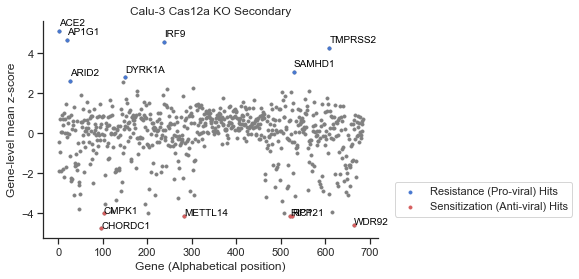

In [19]:
alphabetical_scatter(df=gene_residual_sheet, title = 'Calu-3 Cas12a KO Secondary', filename='Calu3_Cas12a_KO_Secondary', 
                     num_hits=[7,6])

In [20]:
len(gene_residual_sheet)

684

### Cas9 KO vs Cas12a KO

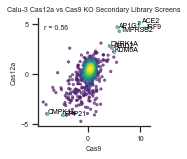

In [22]:
Cas9_KO_secondary_library = pd.read_excel('Data/GSE193834_Supplemental_File_11_Calu-3_Cas9_KO_SecondaryLibrary_Goujon.xlsx')
Cas9_KO_secondary_library

secondary_library_ko = pd.merge(Cas9_KO_secondary_library, gene_residual_sheet, on = 'Gene Symbol', how = 'inner', suffixes=['_Cas9', '_Cas12a'])
secondary_library_ko = secondary_library_ko.rename(columns = {'residual_zscore_avg':'residual_zscore_avg_Cas9', 'residual_zscore':'residual_zscore_Cas12a'})


fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(secondary_library_ko, 'residual_zscore_avg_Cas9', 'residual_zscore_Cas12a', s=6)
ax = gpp.add_correlation(secondary_library_ko, 'residual_zscore_avg_Cas9', 'residual_zscore_Cas12a', fontsize=7)

top_ranked_screen1 = secondary_library_ko.nsmallest(10, 'residual_zscore_avg_Cas9')
top_ranked_screen2 = secondary_library_ko.nsmallest(10, 'residual_zscore_Cas12a')
bottom_ranked_screen1 = secondary_library_ko.nlargest(10, 'residual_zscore_avg_Cas9')
bottom_ranked_screen2 = secondary_library_ko.nlargest(10, 'residual_zscore_Cas12a')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_avg_Cas9', 'residual_zscore_Cas12a'], how = 'inner')
common_ranked

sns.scatterplot(data=common_ranked, x='residual_zscore_avg_Cas9', y='residual_zscore_Cas12a', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in common_ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Cas9']+0.25, row['residual_zscore_Cas12a'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Calu-3 Cas12a vs Cas9 KO Secondary Library Screens', fontsize=7)
plt.xlabel('Cas9', fontsize=7)
plt.ylabel('Cas12a', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
# fig.savefig('../../../Figures/Scatterplots/Calu3_Cas12avsCas9_KO_Secondary_Screen_scatterplot.png', dpi=300, bbox_inches = 'tight')
# gpp.savefig('../../../Figures/Scatterplots/Calu3_Cas12avsCas9_KO_Secondary_Screen_scatterplot.pdf', dpi=300)




### Primary vs Cas12a Secondary Calu3 KO screens

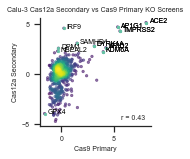

In [24]:
Cas9_KO_Calu3_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_Supplemental_File_3_Calu-3_KO_Gattinara_Goujon.xlsx')
Cas9_KO_Calu3_primary

primaryvssecondaryKO_Cas9vsCas12a = pd.merge(Cas9_KO_Calu3_primary, gene_residual_sheet, on = 'Gene Symbol', how = 'inner', suffixes=['_Cas9_primary', '_Cas12a_secondary'])
primaryvssecondaryKO_Cas9vsCas12a = primaryvssecondaryKO_Cas9vsCas12a.rename(columns={'residual_zscore_avg': 'residual_zscore_avg_Cas9_primary','residual_zscore':'residual_zscore_Cas12a_secondary' })

fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(primaryvssecondaryKO_Cas9vsCas12a, 'residual_zscore_avg_Cas9_primary', 'residual_zscore_Cas12a_secondary', s=6)
ax = gpp.add_correlation(primaryvssecondaryKO_Cas9vsCas12a, 'residual_zscore_avg_Cas9_primary', 'residual_zscore_Cas12a_secondary', fontsize=7, loc = 'lower right')

top_ranked_screen1 = primaryvssecondaryKO_Cas9vsCas12a.nlargest(10, 'residual_zscore_avg_Cas9_primary')
top_ranked_screen2 = primaryvssecondaryKO_Cas9vsCas12a.nlargest(10, 'residual_zscore_Cas12a_secondary')
bottom_ranked_screen1 = primaryvssecondaryKO_Cas9vsCas12a.nsmallest(10, 'residual_zscore_avg_Cas9_primary')
bottom_ranked_screen2 = primaryvssecondaryKO_Cas9vsCas12a.nsmallest(10, 'residual_zscore_Cas12a_secondary')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_avg_Cas9_primary', 'residual_zscore_Cas12a_secondary'], how = 'inner')
common_ranked
annot_df = pd.concat([common_ranked, top_ranked_screen2]).drop_duplicates()

sns.scatterplot(data=annot_df, x='residual_zscore_avg_Cas9_primary', y='residual_zscore_Cas12a_secondary', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in annot_df.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Cas9_primary']+0.25, row['residual_zscore_Cas12a_secondary'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Calu-3 Cas12a Secondary vs Cas9 Primary KO Screens', fontsize=7)
plt.xlabel('Cas9 Primary', fontsize=7)
plt.ylabel('Cas12a Secondary', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
# fig.savefig('../../../Figures/Scatterplots/Calu3_KO_Cas9PrimaryvsCas12aSecondary_scatterplot.png', bbox_inches = 'tight', dpi=300)
# gpp.savefig('../../../Figures/Scatterplots/Calu3_KO_Cas9PrimaryvsCas12aSecondary_scatterplot.pdf', dpi=300)




In [ ]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
#     zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
#     gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)